# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import ks_2samp

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [7]:
def analise_bivariada(df, var_resposta, var_explicativa):
    # Criando uma tabela de contingência entre as variáveis explicativa e resposta.
    tab = pd.crosstab(index=df[var_explicativa], columns=df[var_resposta], margins=True, margins_name='total')

    # Calculando a probabilidade de ocorrência da variável resposta para cada valor da variável explicativa.
    tab['prob'] = tab[1] / tab['total']

    # Calculando as odds de ocorrência da variável resposta para cada valor da variável explicativa.
    tab['odds'] = tab[1] / tab[0]

    # Calculando o odds ratio.
    tab['odds_ratio'] = tab['odds'] / tab.loc['total', 'odds']

    # Calculando o logito.
    tab['logito'] = np.log(tab['odds'])

    # Calculando o Weight of Evidence (WOE).
    tab['WOE'] = np.log(tab['odds'] / tab.loc['total', 'odds'])

    return tab

In [8]:
analise_bivariada(df, 'flag_doente', 'sex')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [9]:
analise_bivariada(df, 'flag_doente', 'cp')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [10]:
analise_bivariada(df, 'flag_doente', 'fbs')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [12]:
def analise_bivariada_quantitativa(df, var_resposta, var_explicativa, num_grupos=5):
    df[var_explicativa + '_cat'] = pd.cut(df[var_explicativa], bins=num_grupos)

    # Criando a tabela de contingência.
    tab = pd.crosstab(index=df[var_explicativa + '_cat'],columns=df[var_resposta], margins=True, margins_name='total')

    tab['prob'] = tab[1] / tab['total']
    tab['odds'] = tab[1] / tab[0]
    tab['odds_ratio'] = tab['odds'] / tab.loc['total', 'odds']
    tab['logito'] = np.log(tab['odds'])
    tab['WOE'] = np.log(tab['odds'] / tab.loc['total', 'odds'])

    return tab

In [13]:
analise_bivariada_quantitativa(df, 'flag_doente', 'age')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
age_cat,,,,,,,,
"(28.952, 38.6]",8,3,11,0.272727,0.375000,0.442446,-0.980829,-0.815437
"(38.6, 48.2]",50,21,71,0.295775,0.420000,0.495540,-0.867501,-0.702108
"(48.2, 57.8]",56,41,97,0.422680,0.732143,0.863823,-0.311780,-0.146387
"(57.8, 67.4]",40,67,107,0.626168,1.675000,1.976259,0.515813,0.681206
"(67.4, 77.0]",10,7,17,0.411765,0.700000,0.825899,-0.356675,-0.191282
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [15]:
# Def variáveis dependentes e independentes.
X = df[['sex', 'cp', 'trestbps', 'age']]
y = df['flag_doente']

In [16]:
# Adicionando uma constante as variáveis independentes.
X = sm.add_constant(X)

# Construindo o modelo.
model = sm.Logit(y, X)

# Ajustando o modelo.
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                  0.2605
Time:                        17:38:48   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.

# Realizando a análise:

- age (idade): A cada um ano de aumento na idade há o aumento do log-odds de ter doença cardíaca em 0.0582 vezes.

- sex: Os homens possuem um log-odds de ter doença cardíaca 1.8021 vezes maior em relação as mulheres.

- trestbps(pressão sanguínea em repouso): Mantendo as demais variáveis constantes há um aumento no log-odds de ter doença cardíaca em 0.0214 vezes para o aumento de uma unidade na pressão sanguínea.

--------------------------------------

4. Avalie o seu modelo quanto a **calibragem**:

- Calcule a probabilidade de evento predita segundo o seu modelo

In [27]:
df['predito'] = result.predict(X)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,age_cat,prob_pred,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(57.8, 67.4]",0.196041,0.196041
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(57.8, 67.4]",0.928431,0.928431
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(57.8, 67.4]",0.846558,0.846558
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(28.952, 38.6]",0.276207,0.276207
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(38.6, 48.2]",0.024768,0.024768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1,"(38.6, 48.2]",0.038935,0.038935
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1,"(67.4, 77.0]",0.907123,0.907123
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1,"(48.2, 57.8]",0.792496,0.792496
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1,1,"(48.2, 57.8]",0.060505,0.060505


- Categorize essa probabilidade em G=5 grupos

In [29]:
pred_cat = pd.qcut(x=df['predito'], q=5)

In [31]:
group_reg = df.groupby(by=pred_cat)

C:\Users\renna\AppData\Local\Temp\ipykernel_24076\515451029.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_reg = df.groupby(by=pred_cat)


In [33]:
qualid = (group_reg[['flag_doente']].count().rename(columns={'flag_doente':'contagem'}))
qualid

,contagem
predito,
"(0.0119, 0.146]",61
"(0.146, 0.349]",60
"(0.349, 0.575]",61
"(0.575, 0.772]",60
"(0.772, 0.928]",61


- Calcule a probabilidade de evento predita média por grupo

In [35]:
qualid['predito'] = group_reg['predito'].mean()
qualid

,contagem,predito
predito,,
"(0.0119, 0.146]",61,0.076255
"(0.146, 0.349]",60,0.249060
"(0.349, 0.575]",61,0.457982
"(0.575, 0.772]",60,0.673059
"(0.772, 0.928]",61,0.837449


- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo

In [41]:
# Calculando a taxa de eventos por grupo
qualid['pct_doente'] = group_reg['flag_doente'].mean()
qualid

,contagem,predito,pct_doente
predito,,,
"(0.0119, 0.146]",61,0.076255,0.098361
"(0.146, 0.349]",60,0.249060,0.183333
"(0.349, 0.575]",61,0.457982,0.491803
"(0.575, 0.772]",60,0.673059,0.683333
"(0.772, 0.928]",61,0.837449,0.836066


- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

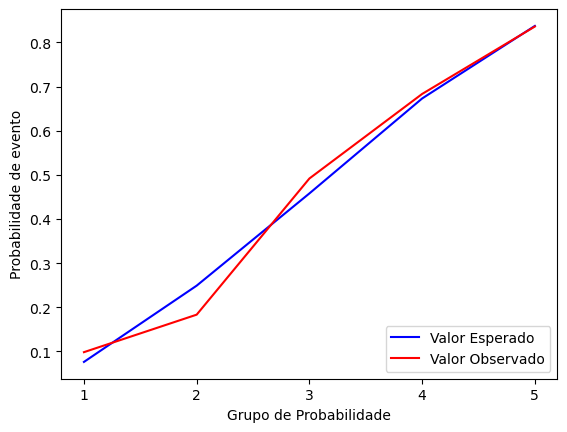

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plotando a probabilidade média de evento (valor esperado) por grupo
qualid['predito'].plot(ax=ax, label='Valor Esperado', color='blue')

# Plotando a taxa de eventos (valor observado) por grupo
qualid['pct_doente'].plot(ax=ax, label='Valor Observado', color='red')

# Configurando os ticks do eixo x
ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])

# Adicionando legenda e rótulos dos eixos
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento', color = 'black')
ax.set_xlabel('Grupo de Probabilidade', color = 'black')

plt.show()

In [58]:
qualid.columns

Index(['contagem', 'predito', 'pct_doente'], dtype='object')

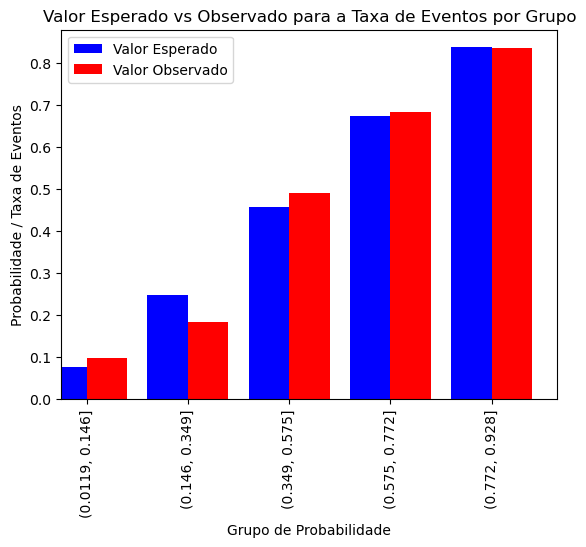

In [66]:
fig, ax = plt.subplots()

# Plotando a probabilidade média de evento por grupo
qualid['predito'].plot(kind='bar', ax=ax, color='blue', width=0.4, position=1)

# Plotando a taxa de eventos por grupo
qualid['pct_doente'].plot(kind='bar', ax=ax, color='red', width=0.4, position=0)

# Configurando os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Grupo de Probabilidade', color = 'black')
ax.set_ylabel('Probabilidade / Taxa de Eventos', color = 'black')
ax.set_title('Valor Esperado vs Observado para a Taxa de Eventos por Grupo', color = 'black')

# Adicionando a legenda
ax.legend(['Valor Esperado', 'Valor Observado'])

plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [69]:
# Calculando as previsões do modelo
y_pred = result.predict(X)

# Binarizando as previsões para calcular a acurácia
y_pred_bin = [1 if p > 0.5 else 0 for p in y_pred]

# Calculando a acurácia
acuracia = accuracy_score(y, y_pred_bin)

# Calculando o coeficiente de Gini
gini = 2 * roc_auc_score(y, y_pred) - 1

# Calculando a estatística KS
ks = ks_2samp(y_pred[y == 1], y_pred[y == 0]).statistic

print(f'Acurácia: {acuracia*100:.2f}%')
print(f'Gini: {gini*100:.2f}%')
print(f'KS: {ks*100:.2f}%')

Acurácia: 77.89%
Gini: 66.22%
KS: 58.40%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [83]:
df.dtypes

age             float64
sex             float64
cp              float64
trestbps        float64
chol            float64
fbs             float64
restecg         float64
thalach         float64
exang           float64
oldpeak         float64
slope           float64
ca               object
thal             object
num               int64
flag_doente       int64
age_cat        category
prob_pred       float64
predito         float64
dtype: object

In [85]:
reglog = smf.logit(formula='''flag_doente 
                            ~ age
                            + sex 
                            + C(cp, Treatment(reference=4))
                            + thalach
                            + exang
                            + oldpeak
                            ''', 
                   data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.414266
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                  0.3994
Time:                        18:02:42   Log-Likelihood:                -125.52
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 5.652e-32
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.6474      2.025     -0.320      0.749      -4.617       3.322
C(cp, Treatment(reference=4))[T.1.0]    -2.1539      0.594     -3.625      0.000      -3.319      -0.989
C(cp, Treatment(reference=4))[T.2.0]    -1.4851      0.485     -3.065      0.002      -2.435      -0.535
C(cp, Treatment(reference=4))[T.3.0]    -1.9797      0.405     -4.893      0.000      -2.773      -1.187
age                                      0.0394      0.020      1.984      0.047       0.000       0.078
sex                                      1.6929      0.379      4.463      0.000       0.949       2.436
thalach                                 -0.0192      0.009     -2.207      0.027      -0.036      -0.002
exang                                    0.8612      0.366      2.354      0.019       0.144       1.578
oldpeak                                  0.6968      0.170      4.108      0.000       0.364       1.029
========================================================================================================
"""

In [89]:
df['predito'] = reglog.predict(exog=df)

# Categorizando essa probabilidade em 5 grupos:
pred_cat = pd.qcut(x=df['predito'], q=5)
group_reg = df.groupby(by=pred_cat)
qualid = (group_reg[['flag_doente']].count().rename(columns={'flag_doente':'contagem'}))

# Calculando a probabilidade de evento predita média por grup:
qualid['predito'] = group_reg['predito'].mean()

# Calculando a taxa de eventos (média da variável indicadora de eventos) por grupo:
qualid['pct_doente'] = group_reg['flag_doente'].mean()

# Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito'] > .5)
print('Acurácia: {0:.2f}%'.format(acc*100))

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

# GINI
gini = 2 * auc_ -1

# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

# print(f'AUC: {auc_*100:.2f}%')
print(f'GINI: {gini*100:.2f}%')
print(f'KS: {ks*100:.2f}%')

Acurácia: 82.84%
GINI: 78.04%
KS: 66.27%


C:\Users\renna\AppData\Local\Temp\ipykernel_24076\3517688823.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_reg = df.groupby(by=pred_cat)


---------------------------